## Finalize short and long harmonized AnnData after Seurat SCT for M132TS

This notebooks takes the Seurat SCT output and previously harmonized long-reads and short-reads AnnData objects, performs a final round of filtering (e.g. doublet removal) clustering, and annotation, and outputs four analysis-ready AnnData outputs (short/long, raw/SCT)

**Inputs and Outputs**
- Inputs:
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes)
  - harmonized long-reads and short-reads AnnData objects (SCT counts, all genes) [from Seurat script]
- Outputs:
  - Four AnnData objects, each including the same cluster annotations and embeddings
    - short raw
    - short SCT
    - long raw
    - long SCT
  - Figures

In [1]:
%matplotlib inline

import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import os
import sys
from time import time
import logging
import pickle
from operator import itemgetter

import scanpy as sc

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

# inputs
input_prefix = 'M132TS_immune.v4.harmonized'
output_path = 'output/t-cell-vdj-cite-seq'

harmonized_short_adata_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.h5ad')
harmonized_long_adata_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.h5ad')

harmonized_short_adata_seurat_output_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.seurat_output.no_mt_pct_regression.h5ad')
harmonized_long_adata_seurat_output_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.seurat_output.no_mt_pct_regression.h5ad')

# outputs
final_short_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.raw.h5ad')
final_short_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.short.stringtie.final.sct.h5ad')
final_long_adata_raw_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.raw.h5ad')
final_long_adata_sct_h5_path = os.path.join(repo_root, output_path, f'{input_prefix}.long.stringtie.final.sct.h5ad')

In [3]:
n_sct_features = 5000
n_pcs = 30
n_neighbors = 100
n_neighbors_umap = 100
umap_min_dist = 0.1
umap_spread = 20.0
metric = 'euclidean'

# neglect highly expressed genes for clustering?
neglect_high_expression_fraction = 0.0

## Short adata final clustering (using SCT features)

In [4]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))
adata_short_seurat = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].


In [5]:
# highly variable?
adata_short_seurat.var['rv'] = np.var(adata_short_seurat.X, axis=0)
rv_cutoff = np.sort(adata_short_seurat.var['rv'])[::-1][n_sct_features]
adata_short_seurat.var['hv'] = adata_short_seurat.var['rv'] > rv_cutoff

# expression in range?
expr_cutoff = np.sort(adata_short_raw.var['mean_counts'].values)[::-1][
    int(neglect_high_expression_fraction * len(adata_short_raw.var))]
expr_in_range = adata_short_raw.var['mean_counts'] <= expr_cutoff
adata_short_seurat.var['eir'] = expr_in_range[adata_short_seurat.var.index]

# subset to highly variable and expression-in-range features
adata_short_seurat = adata_short_seurat[:, adata_short_seurat.var['hv'] & adata_short_seurat.var['eir']]

# scale
sc.pp.scale(adata_short_seurat)
sc.tl.pca(adata_short_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_short_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

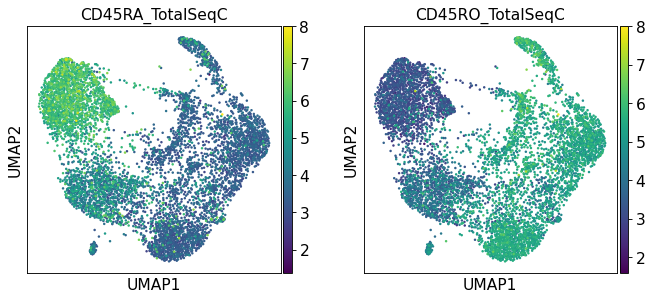

In [8]:
from umap import UMAP

adata_short_seurat.obsm['X_umap'] = UMAP(
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    metric=metric).fit_transform(adata_short_seurat.obsm['X_pca'])

adata_short_seurat.obs['CD45_TotalSeqC'] = adata_short_raw.obs['CD45_TotalSeqC']
adata_short_seurat.obs['CD45R_B220_TotalSeqC'] = adata_short_raw.obs['CD45R_B220_TotalSeqC']
adata_short_seurat.obs['CD45RA_TotalSeqC'] = adata_short_raw.obs['CD45RA_TotalSeqC']
adata_short_seurat.obs['CD45RO_TotalSeqC'] = adata_short_raw.obs['CD45RO_TotalSeqC']

sc.pl.umap(adata_short_seurat, color=['CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'], s=20, vmax=8)

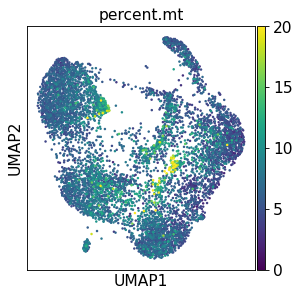

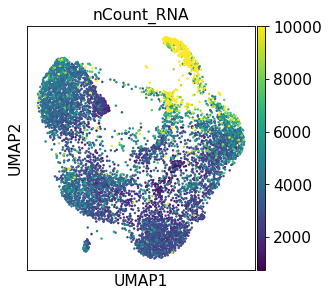

In [9]:
sc.pl.umap(adata_short_seurat, color=['percent.mt'], s=20, vmax=20)
sc.pl.umap(adata_short_seurat, color=['nCount_RNA'], s=20, vmax=10000)

## Preliminary clustering, doublet scrubbing, and proof-reading

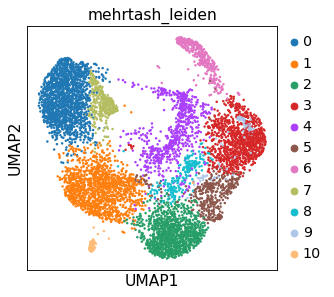

In [10]:
sc.tl.leiden(adata_short_seurat, resolution=1.3, key_added='mehrtash_leiden')
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

In [11]:
import scrublet as scr

scrub = scr.Scrublet(adata_short_raw.X, expected_doublet_rate=0.12)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

adata_short_seurat.obs['doublet_scores'] = doublet_scores
adata_short_seurat.obs['predicted_doublets'] = predicted_doublets.astype(np.int)
adata_short_seurat.obs['predicted_doublets_0.20'] = (doublet_scores > 0.20).astype(np.int)
adata_short_seurat.obs['predicted_doublets_0.25'] = (doublet_scores > 0.25).astype(np.int)
adata_short_seurat.obs['predicted_doublets_0.30'] = (doublet_scores > 0.30).astype(np.int)
adata_short_seurat.obs['predicted_doublets_0.35'] = (doublet_scores > 0.35).astype(np.int)
adata_short_seurat.obs['predicted_doublets_0.40'] = (doublet_scores > 0.40).astype(np.int)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 15.6%
Estimated detectable doublet fraction = 64.4%
Overall doublet rate:
	Expected   = 12.0%
	Estimated  = 24.3%
Elapsed time: 6.2 seconds


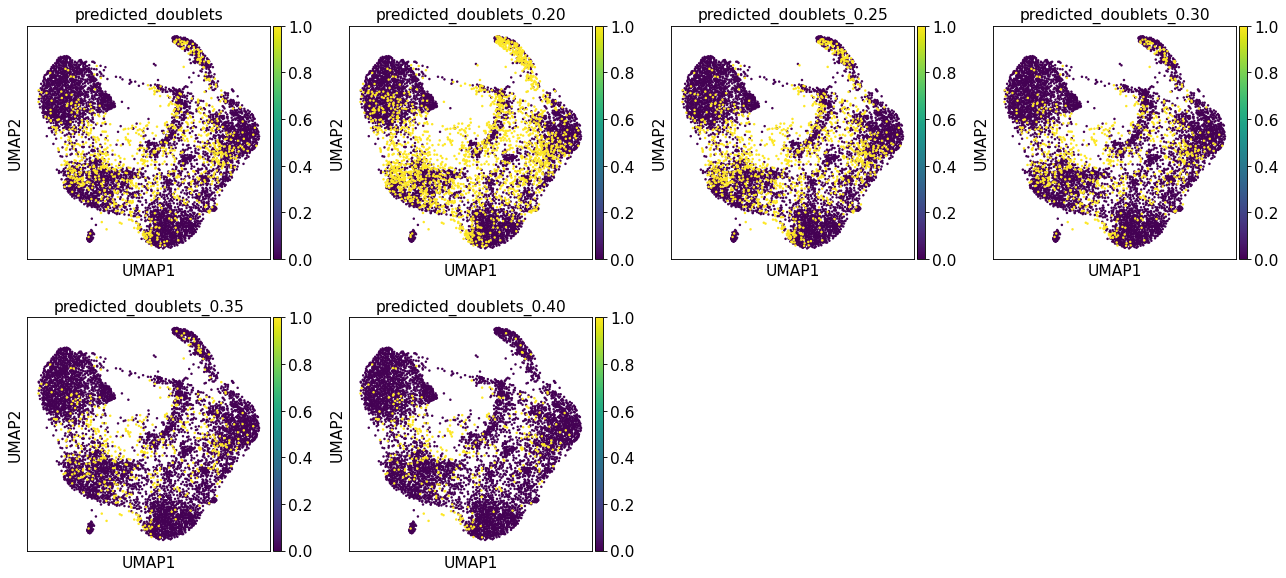

In [12]:
doublet_keys = [
    'predicted_doublets',
    'predicted_doublets_0.20',
    'predicted_doublets_0.25',
    'predicted_doublets_0.30',
    'predicted_doublets_0.35',
    'predicted_doublets_0.40'
]

sc.pl.umap(adata_short_seurat, color=doublet_keys, s=20)

In [13]:
for key in doublet_keys:
    log_info(f'{key}, doublet fraction: {np.sum(adata_short_seurat.obs[key]) / len(adata_short_seurat):.3f}')

predicted_doublets, doublet fraction: 0.156
predicted_doublets_0.20, doublet fraction: 0.309
predicted_doublets_0.25, doublet fraction: 0.191
predicted_doublets_0.30, doublet fraction: 0.125
predicted_doublets_0.35, doublet fraction: 0.082
predicted_doublets_0.40, doublet fraction: 0.057


Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].


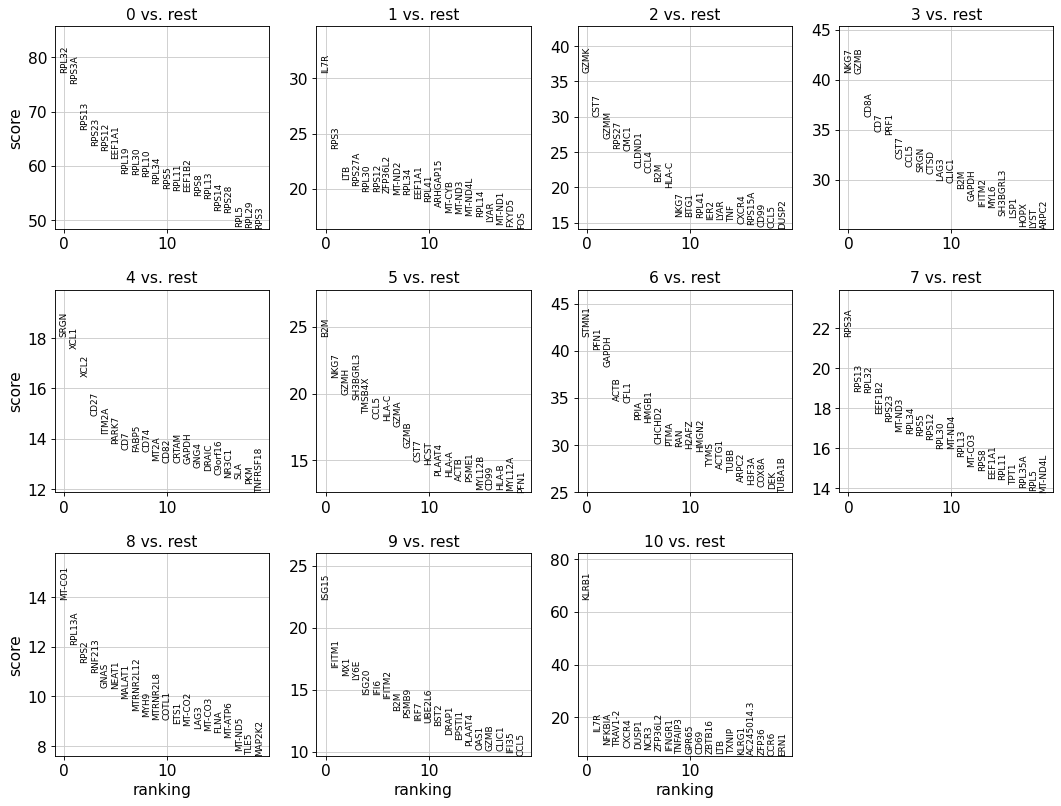

In [14]:
adata_short_seurat_full = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))
adata_short_seurat_full.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_short_seurat_full.raw = None
adata_test = adata_short_seurat_full

sc.tl.rank_genes_groups(adata_test, 'mehrtash_leiden', method='t-test')
sc.pl.rank_genes_groups(adata_test, n_genes=20, sharey=False)

In [15]:
unwanted_leiden_ids = {
    '8', # MT- high
}

final_barcodes = adata_short_seurat[
    (~adata_short_seurat.obs['mehrtash_leiden'].isin(unwanted_leiden_ids)) &
    (~adata_short_seurat.obs['predicted_doublets_0.30'].astype(np.bool))].obs.index

## Final clustering

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Trying to set attribute `.var` of view, copying.


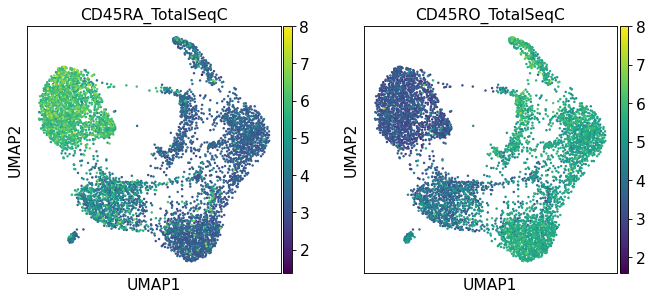

In [16]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))[final_barcodes]
adata_short_seurat = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]

adata_short_seurat.var['rv'] = np.var(adata_short_seurat.X, axis=0)
rv_cutoff = np.sort(adata_short_seurat.var['rv'])[::-1][n_sct_features]
adata_short_seurat.var['hv'] = adata_short_seurat.var['rv'] > rv_cutoff
adata_short_seurat = adata_short_seurat[:, adata_short_seurat.var['hv']]

sc.pp.scale(adata_short_seurat)
sc.tl.pca(adata_short_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_short_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

adata_short_seurat.obsm['X_umap'] = UMAP(
    random_state=1,
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    metric=metric).fit_transform(adata_short_seurat.obsm['X_pca'])

adata_short_seurat.obs['CD45_TotalSeqC'] = adata_short_raw.obs['CD45_TotalSeqC']
adata_short_seurat.obs['CD45R_B220_TotalSeqC'] = adata_short_raw.obs['CD45R_B220_TotalSeqC']
adata_short_seurat.obs['CD45RA_TotalSeqC'] = adata_short_raw.obs['CD45RA_TotalSeqC']
adata_short_seurat.obs['CD45RO_TotalSeqC'] = adata_short_raw.obs['CD45RO_TotalSeqC']

sc.pl.umap(adata_short_seurat, color=['CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'], s=20, vmax=8)

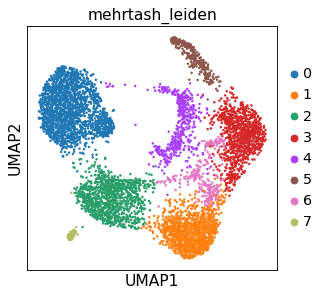

In [17]:
sc.tl.leiden(adata_short_seurat, resolution=1.1, key_added='mehrtash_leiden')
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

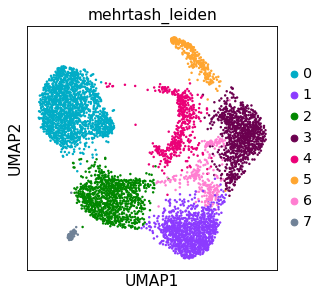

In [18]:
import colorcet as cc

def rgb_to_hex(x) -> str: 
    r = max(0, min(int(255 * x[0]), 255))
    g = max(0, min(int(255 * x[1]), 255))
    b = max(0, min(int(255 * x[2]), 255))
    return "#{0:02x}{1:02x}{2:02x}".format(r, g, b)

leiden_categories = adata_short_seurat.obs['mehrtash_leiden'].values.categories
n_leiden = len(leiden_categories)
i_order = [3, 1, 2, 6, 26, 7, 5, 33]
leiden_color_list = [rgb_to_hex(cc.cm.glasbey(i)[:3]) for i in i_order]
leiden_color_map = {
    color: category
    for category, color in zip(
        adata_short_seurat.obs['mehrtash_leiden'].values.categories,
        leiden_color_list)}

adata_short_seurat.uns['mehrtash_leiden_colors'] = leiden_color_map
sc.pl.umap(adata_short_seurat, color=['mehrtash_leiden'], s=20)

Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Trying to set attribute `.obs` of view, copying.


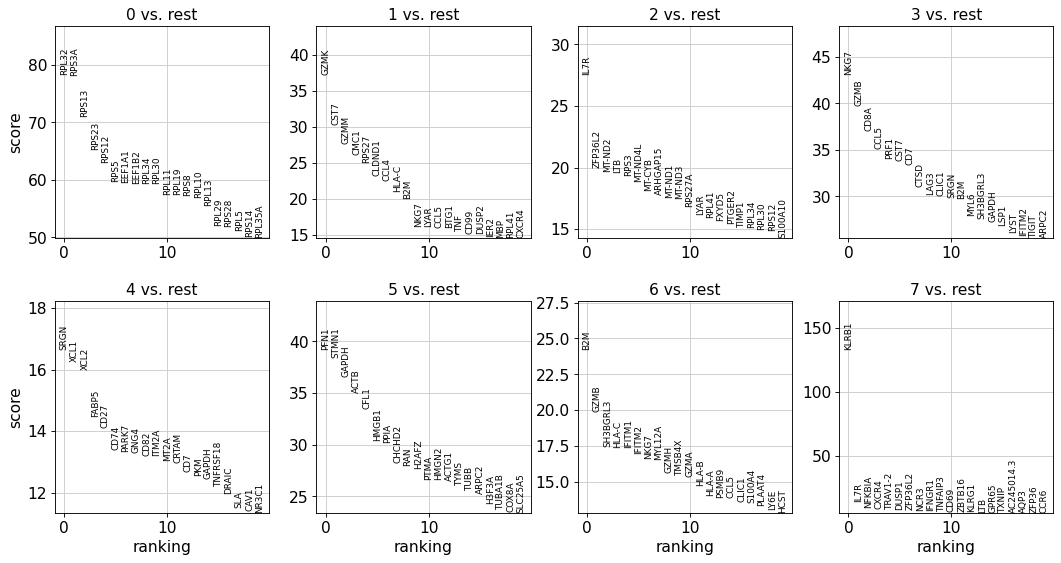

In [19]:
adata_short_seurat_full = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]
adata_short_seurat_full.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_short_seurat_full.raw = None
adata_test = adata_short_seurat_full

sc.tl.rank_genes_groups(adata_test, 'mehrtash_leiden', method='t-test')
sc.pl.rank_genes_groups(adata_test, n_genes=20, sharey=False)

In [20]:
mehrtash_leiden_names_map = {
    '0': 'SMC',
    '1': 'A I',
    '2': 'EA',
    '3': 'E',
    '4': 'A III',
    '5': 'P',
    '6': 'A II',
    '7': 'A IV'
}

leiden_names = []
for leiden_id in adata_short_seurat.obs['mehrtash_leiden'].values:
    leiden_names.append(mehrtash_leiden_names_map[leiden_id])
new_color_map = {
    color: mehrtash_leiden_names_map[old_category]
    for color, old_category in adata_short_seurat.uns['mehrtash_leiden_colors'].items()}
adata_short_seurat.obs['mehrtash_leiden'] = pd.Categorical(leiden_names)
adata_short_seurat.uns['mehrtash_leiden_colors'] = new_color_map

In [21]:
leiden_color_map

{'#00acc6': '0',
 '#8c3bff': '1',
 '#018700': '2',
 '#6b004f': '3',
 '#eb0077': '4',
 '#ffa52f': '5',
 '#ff7ed1': '6',
 '#708297': '7'}

## Long adata final clustering (using SCT features)

In [22]:
n_sct_features = 5000
n_pcs = 30
n_neighbors = 100
n_neighbors_umap = 100
umap_min_dist = 0.1
umap_spread = 20.0
metric = 'euclidean'

In [23]:
adata_long_raw = sc.read(os.path.join(repo_root, harmonized_long_adata_h5_path))[final_barcodes]
adata_long_seurat = sc.read(os.path.join(repo_root, harmonized_long_adata_seurat_output_h5_path))[final_barcodes]

adata_long_seurat.var['rv'] = np.var(adata_long_seurat.X, axis=0)
rv_cutoff = np.sort(adata_long_seurat.var['rv'])[::-1][n_sct_features]
adata_long_seurat.var['hv'] = adata_long_seurat.var['rv'] > rv_cutoff
adata_long_seurat = adata_long_seurat[:, adata_long_seurat.var['hv']]

sc.pp.scale(adata_long_seurat)
sc.tl.pca(adata_long_seurat, svd_solver='arpack', n_comps=n_pcs)
sc.pp.neighbors(adata_long_seurat, n_neighbors=n_neighbors, n_pcs=n_pcs, metric=metric)

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Trying to set attribute `.var` of view, copying.


In [24]:
from umap import UMAP

adata_long_seurat.obsm['X_umap'] = UMAP(
    densmap=False,
    min_dist=umap_min_dist,
    spread=umap_spread,
    n_neighbors=n_neighbors_umap,
    init=adata_short_seurat.obsm['X_umap'],
    metric=metric).fit_transform(adata_long_seurat.obsm['X_pca'])

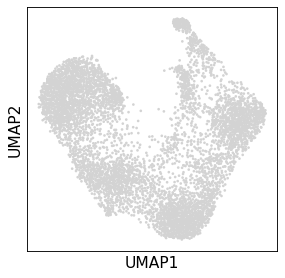

In [25]:
sc.pl.umap(adata_long_seurat)

In [26]:
adata_long_seurat.obs['CD45_TotalSeqC'] = adata_long_raw.obs['CD45_TotalSeqC']
adata_long_seurat.obs['CD45R_B220_TotalSeqC'] = adata_long_raw.obs['CD45R_B220_TotalSeqC']
adata_long_seurat.obs['CD45RA_TotalSeqC'] = adata_long_raw.obs['CD45RA_TotalSeqC']
adata_long_seurat.obs['CD45RO_TotalSeqC'] = adata_long_raw.obs['CD45RO_TotalSeqC']
adata_long_seurat.obs['mehrtash_leiden'] = adata_short_seurat.obs['mehrtash_leiden']
adata_long_seurat.uns['mehrtash_leiden_colors'] = adata_short_seurat.uns['mehrtash_leiden_colors']

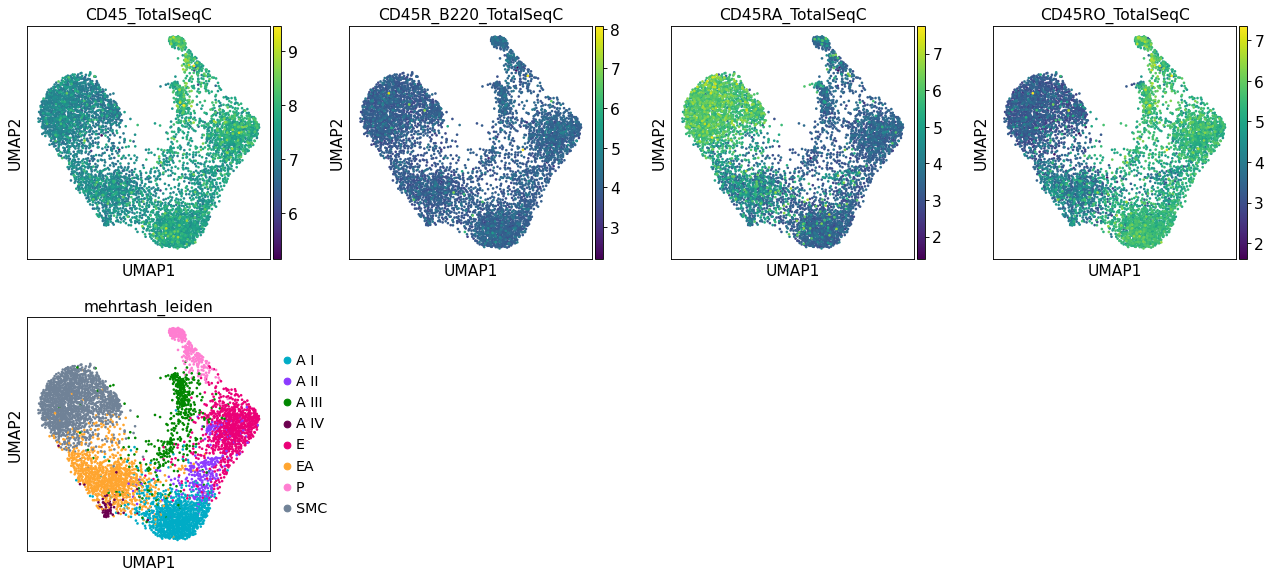

In [27]:
sc.pl.umap(adata_long_seurat, color=['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'mehrtash_leiden'])

## Save

In [28]:
mehrtash_leiden = adata_short_seurat.obs['mehrtash_leiden']
mehrtash_leiden_colors = adata_short_seurat.uns['mehrtash_leiden_colors']

categories = mehrtash_leiden.values.categories
category_to_color = {category: color for color, category in mehrtash_leiden_colors.items()}
mehrtash_leiden_colors = list(map(category_to_color.get, categories))

adata_long_X_pca_SCT = adata_long_seurat.obsm['X_pca']
adata_long_X_umap_SCT = adata_long_seurat.obsm['X_umap']

adata_short_X_pca_SCT = adata_short_seurat.obsm['X_pca']
adata_short_X_umap_SCT = adata_short_seurat.obsm['X_umap']

In [29]:
adata_short_raw = sc.read(os.path.join(repo_root, harmonized_short_adata_h5_path))[final_barcodes]

adata_short_X_pca_raw = adata_short_raw.obsm['X_pca']
adata_short_X_tsne_raw = adata_short_raw.obsm['X_tsne']

adata_short_raw.uns.clear()
adata_short_raw.obsm.clear()

adata_short_raw.obsm['X_pca_SCT_short'] = adata_short_X_pca_SCT
adata_short_raw.obsm['X_pca_SCT_long'] = adata_long_X_pca_SCT

adata_short_raw.obsm['X_umap_SCT_short'] = adata_short_X_umap_SCT
adata_short_raw.obsm['X_umap_SCT_long'] = adata_long_X_umap_SCT

adata_short_raw.obsm['X_tsne_raw_short'] = adata_short_X_tsne_raw
adata_short_raw.obsm['X_pca_raw_short'] = adata_short_X_pca_raw

adata_short_raw.obs['mehrtash_leiden'] = mehrtash_leiden
adata_short_raw.uns['mehrtash_leiden_colors'] = mehrtash_leiden_colors

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].


In [30]:
adata_short_sct = sc.read(os.path.join(repo_root, harmonized_short_adata_seurat_output_h5_path))[final_barcodes]

adata_short_sct.raw = None
adata_short_sct.uns.clear()
adata_short_sct.varm.clear()
adata_short_sct.obsp.clear()
adata_short_sct.obs = adata_short_raw.obs
adata_short_sct.obsm = adata_short_raw.obsm
adata_short_sct.uns = adata_short_raw.uns
adata_short_sct.var = adata_short_raw[:, adata_short_sct.var.index].var

Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].


In [31]:
adata_long_raw = sc.read(os.path.join(repo_root, harmonized_long_adata_h5_path))[final_barcodes]

adata_long_raw.uns.clear()
adata_long_raw.obsm.clear()

adata_long_raw.obsm['X_pca_SCT_short'] = adata_short_X_pca_SCT
adata_long_raw.obsm['X_pca_SCT_long'] = adata_long_X_pca_SCT

adata_long_raw.obsm['X_umap_SCT_short'] = adata_short_X_umap_SCT
adata_long_raw.obsm['X_umap_SCT_long'] = adata_long_X_umap_SCT

adata_long_raw.obsm['X_tsne_raw_short'] = adata_short_X_tsne_raw
adata_long_raw.obsm['X_pca_raw_short'] = adata_short_X_pca_raw

adata_long_raw.obs['mehrtash_leiden'] = mehrtash_leiden
adata_long_raw.uns['mehrtash_leiden_colors'] = mehrtash_leiden_colors

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].


In [32]:
adata_long_sct = sc.read(os.path.join(repo_root, harmonized_long_adata_seurat_output_h5_path))[final_barcodes]

adata_long_sct.raw = None
adata_long_sct.uns.clear()
adata_long_sct.varm.clear()
adata_long_sct.obsp.clear()
adata_long_sct.obs = adata_long_raw.obs
adata_long_sct.obsm = adata_long_raw.obsm
adata_long_sct.uns = adata_long_raw.uns
adata_long_sct.var = adata_long_raw[:, adata_long_sct.var.index].var

Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].
Only considering the two last: ['.no_mt_pct_regression', '.h5ad'].


In [33]:
adata_short_raw.write(final_short_adata_raw_h5_path)
adata_short_sct.write(final_short_adata_sct_h5_path)
adata_long_raw.write(final_long_adata_raw_h5_path)
adata_long_sct.write(final_long_adata_sct_h5_path)

## Make plots

In [34]:
adata_short_raw = sc.read_h5ad(final_short_adata_raw_h5_path)
adata_short_sct = sc.read_h5ad(final_short_adata_sct_h5_path)
adata_long_raw = sc.read_h5ad(final_long_adata_raw_h5_path)
adata_long_sct = sc.read_h5ad(final_long_adata_sct_h5_path)

In [35]:
def plot_embedding(
        adata: sc.AnnData,
        embedding_key: str,
        leiden_key: str,
        markersize=2,
        alpha=0.75,
        x_offset=dict(),
        y_offset=dict(),
        fig=None,
        ax=None,
        show_labels=True,
        figsize=(3, 3)):
    
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=figsize)

    leiden_color_key = f'{leiden_key}_colors'
    assert leiden_color_key in set(adata.uns.keys())

    leiden_category_to_leiden_color_map = {
        leiden_category: leiden_color
        for leiden_color, leiden_category in zip(
            adata.uns[leiden_color_key],
            adata.obs[leiden_key].values.categories)}
    cell_color_list = list(
        map(leiden_category_to_leiden_color_map.get, adata.obs[leiden_key]))

    ax.scatter(
        adata.obsm[embedding_key][:, 0],
        adata.obsm[embedding_key][:, 1],
        color=cell_color_list,
        s=markersize,
        alpha=alpha)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    if show_labels:
        for leiden_category in adata.obs[leiden_key].values.categories:
            try:
                dx = x_offset[leiden_category]
                dy = y_offset[leiden_category]
            except KeyError:
                dx = 0
                dy = 0
            x_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 0] + dx
            y_values = adata.obsm[embedding_key][adata.obs[leiden_key] == leiden_category, 1] + dy
            x_c, y_c = np.mean(x_values), np.mean(y_values)
            ax.text(
                x_c, y_c, leiden_category,
                fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [36]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

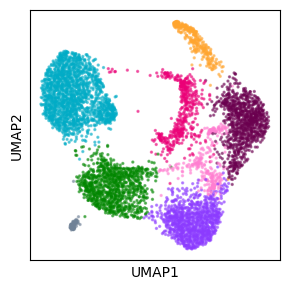

In [37]:
adata = adata_short_raw
embedding_key = 'X_umap_SCT_short'
leiden_key = 'mehrtash_leiden'
x_offset = {'A IV': -22}
y_offset = {'A IV': -2}

fig, ax = plt.subplots(figsize=(3, 3))

plot_embedding(
    adata, embedding_key, leiden_key,
    markersize=2,
    alpha=0.5,
    x_offset=x_offset,
    y_offset=y_offset,
    fig=fig,
    show_labels=False,
    ax=ax)

fig.tight_layout()

plt.savefig('./output/M132TS__UMAP__short.pdf')

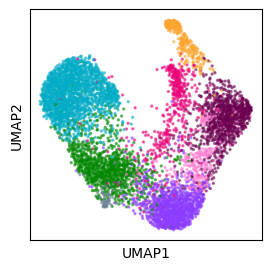

In [38]:
adata = adata_long_raw
embedding_key = 'X_umap_SCT_long'
leiden_key = 'mehrtash_leiden'
x_offset = {'A IV': -7}
y_offset = {'A IV': -16}

fig, ax = plt.subplots(figsize=(3, 3))

plot_embedding(
    adata, embedding_key, leiden_key,
    markersize=2,
    alpha=0.5,
    x_offset=x_offset,
    y_offset=y_offset,
    show_labels=False,
    fig=fig,
    ax=ax)

plt.savefig('./output/M132TS__UMAP__long.pdf')